In [291]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd



In [292]:

import json

#rock sample
with open("/N/project/berkeley_walking/BerkeleyData/berkeley_json/s5_12_rocks_allWalks.json", "r") as f:
    data = json.load(f)
with open("/N/project/berkeley_walking/BerkeleyData/berkeley_json/s5_12_rocks_allWalks.json", "w") as f:
    json.dump(data,f)

#medium sample
with open("/N/project/berkeley_walking/BerkeleyData/berkeley_json/s5_6_medium_allWalks.json", "r") as f:
    data_m = json.load(f)
with open("/N/project/berkeley_walking/BerkeleyData/berkeley_json/s5_6_medium_allWalks.json", "w") as f:
    json.dump(data_m,f)




In [293]:
framerate = data['framerate']

In [294]:
#medium and rock variables are defined on same line for most of remaining cells


frames,frames_m = np.array(data['frames']),np.array(data_m['frames'])
time,time_m = np.array(data['syncedUnixTime']), np.array(data_m['syncedUnixTime'])
time,time_m = time -time[0], time_m -time_m[0]


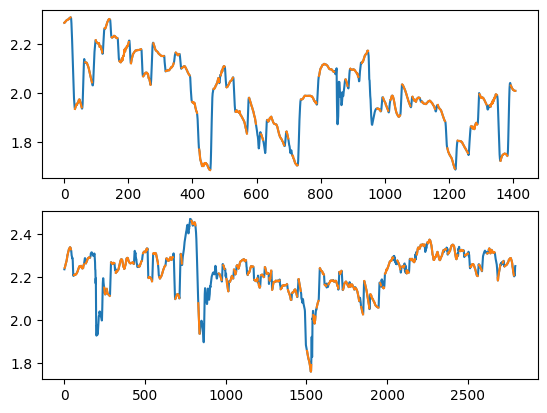

In [295]:
fixation,fixation_m = np.array(data['rEye_blinks'], dtype = bool), np.array(data_m['rEye_blinks'], dtype = bool)
theta,theta_m = np.array(data['rEye_theta']), np.array(data_m['rEye_theta'])
phi = np.array(data['rEye_phi'])
theta_fix, theta_fix_m = np.array(data['rEye_theta']), np.array(data_m['rEye_theta'])
theta_fix[fixation], theta_fix_m[fixation_m] = np.nan, np.nan

plt.subplot(2,1,1)
plt.plot(theta)
plt.plot(theta_fix)

plt.subplot(2,1,2)
plt.plot(theta_m)
plt.plot(theta_fix_m)

In [296]:
fixations_df,fixations_df_m = pd.DataFrame({ 'Frames': frames, 'Time': time, 'Theta': theta,
                             'ThetaFix': theta_fix}), pd.DataFrame({ 'Frames': frames_m, 'Time': time_m, 'Theta': theta_m,
                             'ThetaFix': theta_fix_m})

fixations_df, fixations_df_m = fixations_df.dropna(), fixations_df_m.dropna()
fixations_df['TimeDiffPrev'], fixations_df_m['TimeDiffPrev'] = fixations_df['Time'].diff(), fixations_df_m['Time'].diff()
fixations_df['TimeDiffFol'], fixations_df_m['TimeDiffFol'] = fixations_df['Time'].diff(periods=-1), fixations_df_m['Time'].diff(periods=-1)

FixEnd,FixEnd_m = fixations_df.loc[fixations_df['TimeDiffPrev'] > 0.009], fixations_df_m.loc[fixations_df_m['TimeDiffPrev'] > 0.009]
FixStart,FixStart_m = fixations_df.loc[fixations_df['TimeDiffFol'] < -0.009], fixations_df_m.loc[fixations_df_m['TimeDiffFol'] < -0.009]

In [297]:
steps, steps_m = np.array(data['steps_HS_TO_StanceLeg_XYZ']), np.array(data_m['steps_HS_TO_StanceLeg_XYZ']) #frame step start, frame step end, left/right, XYZ
step_start, step_start_m = steps[:,0].astype(int), steps_m[:,0].astype(int)
step_start_time, step_start_time_m = step_start / framerate, step_start_m / framerate

step_end,step_end_m = steps[:,1].astype(int), steps_m[:,1].astype(int)
step_end_time, step_end_time_m  = step_end / framerate, step_end_m / framerate


step_frames, step_frames_m = steps[:,0:2].astype(int), steps_m[:,0:2].astype(int)
step_time, step_time_m = step_frames.T / framerate, step_frames_m.T / framerate


In [298]:
steps_df, steps_df_m = pd.DataFrame({'FrameStart': steps[:,0], 'FrameEnd': steps[:,1], 'Foot':steps[:,2],
                         'X': steps[:,3],  'Y': steps[:,4],  'Z' :steps[:,5]}), pd.DataFrame({'FrameStart': steps_m[:,0], 'FrameEnd': steps_m[:,1], 'Foot':steps_m[:,2],
                         'X': steps_m[:,3],  'Y': steps_m[:,4],  'Z' :steps_m[:,5]})


steps_df['StartTime'], steps_df_m['StartTime']  = step_start_time, step_start_time_m
steps_df['EndTime'], steps_df_m['EndTime']  = step_end_time, step_end_time_m

right_foot = steps_df.loc[(steps_df['Foot'] == 2)]
left_foot = steps_df.loc[(steps_df['Foot'] == 1)]

(0.0, 1.6)

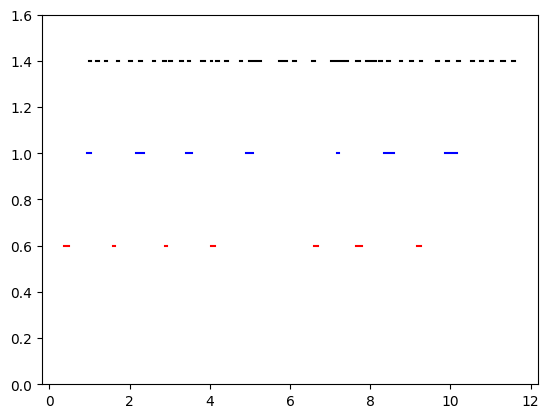

In [299]:
plt.plot((FixStart['Time'][3:], FixEnd['Time'][3:]), np.full_like((FixStart['Time'][3:],FixEnd['Time'][3:]),
                                                                           1.4, dtype=float), color = 'black')  

plt.plot((left_foot['StartTime'],left_foot['EndTime']), np.ones_like((left_foot['StartTime'],left_foot['EndTime'])), color = 'blue')
plt.plot((right_foot['StartTime'],right_foot['EndTime']), np.full_like((right_foot['StartTime'],right_foot['EndTime']),
                                                                            0.6, dtype=float), color = 'red')                                                       
plt.ylim(0,1.6)   

In [300]:
#getting variables for both medium and rock 
fixStart, fixStart_m = np.array(FixStart['Time']), np.array(FixStart_m['Time'])
fixEnd, fixEnd_m = np.array(FixEnd['Time']), np.array(FixEnd_m['Time'])
footfalls, footfalls_m =np.array(steps_df['StartTime']), np.array(steps_df_m['StartTime']) #heel strike

footfalls, footfalls_m = footfalls.reshape(-1,1), footfalls_m.reshape(-1,1)
fixStart, fixStart_m = fixStart.reshape(-1,1), fixStart_m.reshape(-1,1)
fixStop, fixStop_m = fixEnd.reshape(-1,1), fixEnd_m.reshape(-1,1)



#nearest neighbor rock
from sklearn.neighbors import NearestNeighbors

X = footfalls
Start = fixStart
Stop = fixStop

neigh = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X)

    
start_distances, start_indices = neigh.kneighbors(Start)
stop_distances, stop_indices = neigh.kneighbors(Stop)

startNearest = np.array(start_indices)
stopNearest= np.array(stop_indices)
    

In [301]:
#nearest neighbor for medium
neigh = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(footfalls_m)

start_distances_m, start_indices_m = neigh.kneighbors(fixStart_m)
stop_distances_m, stop_indices_m = neigh.kneighbors(fixStop_m)

startNearest_m = np.array(start_indices_m)
stopNearest_m= np.array(stop_indices_m)


In [302]:
#adding the nearest start stop times and indices to each dataframe (medium and rock)
closest_timeStart, closest_timeStart_m = footfalls[startNearest], footfalls_m[startNearest_m]
closest_timeStop, closest_timeStop_m  = footfalls[stopNearest], footfalls_m[stopNearest_m]
closest_timeStart, closest_timeStart_m = closest_timeStart[:,0], closest_timeStart_m[:,0]
closest_timeStop, closest_timeStop_m = closest_timeStop[:,0], closest_timeStop_m[:,0]

nearestFootfalls, nearestFootfalls_m = pd.DataFrame(closest_timeStart, columns = ['TimeNearFixStart']), pd.DataFrame(closest_timeStart_m, columns = ['TimeNearFixStart'])
nearestFootfalls['TimeNearFixStop'], nearestFootfalls_m['TimeNearFixStop'] = closest_timeStop, closest_timeStop_m
nearestFootfalls['IndexNearFixStart'], nearestFootfalls_m['IndexNearFixStart'] = startNearest, startNearest_m
nearestFootfalls['IndexNearFixStop'], nearestFootfalls_m['IndexNearFixStop'] = stopNearest, stopNearest_m


Text(0.5, 1.0, 'MediumStop')

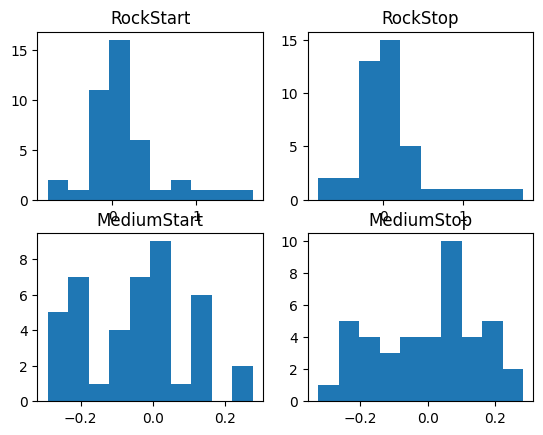

In [321]:
rel_start = []
rel_stop = []
rel_start_m = []
rel_stop_m = []

for x, y,xm,ym in zip(Start,closest_timeStart,fixStart_m,closest_timeStart_m):
    z,zm = x - y, xm-ym
    rel_start.append(z)
    rel_start_m.append(zm)

for x, y,xm,ym in zip(Stop,closest_timeStop,fixStop_m,closest_timeStop_m):
    z,zm = x - y, xm-ym
    rel_stop.append(z)
    rel_stop_m.append(zm)

rel_start_time, rel_start_time_m = np.array(rel_start), np.array(rel_start_m)
rel_stop_time, rel_stop_time_m = np.array(rel_stop), np.array(rel_stop_m)


plt.subplot(2,2,1)
plt.hist(rel_start_time[:,0])
plt.title('RockStart')


plt.subplot(2,2,2)
plt.hist(rel_stop_time[:,0])
plt.title('RockStop')

plt.subplot(2,2,3)
plt.hist(rel_start_time_m[:,0])
plt.title('MediumStart')


plt.subplot(2,2,4)
plt.hist(rel_stop_time_m[:,0])
plt.title('MediumStop')


<Axes: xlabel='RelStart', ylabel='Density'>

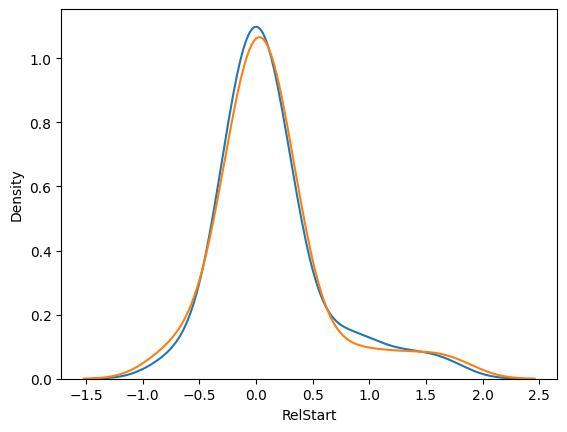

In [304]:
#rel start and stop for rock
import seaborn as sns

rel_start_time = rel_start_time[:,0]
rel_stop_time = rel_stop_time[:,0]

RelFixTimes = pd.DataFrame(rel_start_time, columns=['RelStart'])
RelFixTimes['RelStop'] = rel_stop_time

sns.kdeplot(data=RelFixTimes, x='RelStart')
sns.kdeplot(data=RelFixTimes, x='RelStop')


<Axes: xlabel='RelStart', ylabel='Density'>

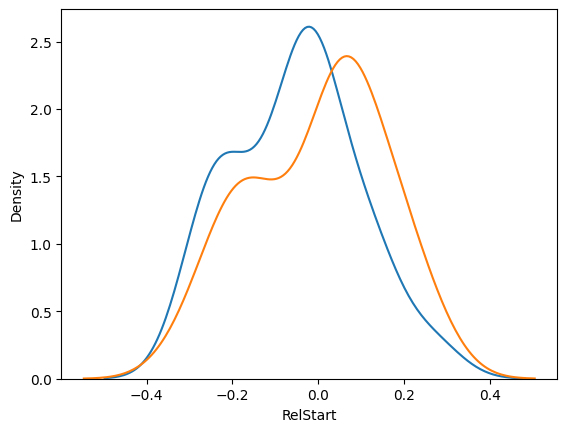

In [305]:
#rel start and stop for medium
import seaborn as sns

rel_start_time_m = rel_start_time_m[:,0]
rel_stop_time_m = rel_stop_time_m[:,0]

RelFixTimes_m = pd.DataFrame(rel_start_time_m, columns=['RelStart'])
RelFixTimes_m['RelStop'] = rel_stop_time_m

sns.kdeplot(data=RelFixTimes_m, x='RelStart')
sns.kdeplot(data=RelFixTimes_m, x='RelStop')

In [306]:
#subtracting previous and next steps in each dataframe, missing stopnext
steps_df['nextdiff'] = steps_df['StartTime'].diff(-1)
steps_df['prevdiff'] = steps_df['StartTime'].diff()
steps_df['prevdiffStop'] = steps_df['EndTime'].diff()

steps_df_m['nextdiff'] = steps_df_m['StartTime'].diff(-1)
steps_df_m['prevdiff'] = steps_df_m['StartTime'].diff()
steps_df_m['prevdiffStop'] = steps_df_m['EndTime'].diff()

In [307]:
#normalizing start and stop times for rock
NormStart = []

for x,y in zip(RelFixTimes['RelStart'],range(len(rel_start))):
        z = nearestFootfalls['IndexNearFixStart'][y]
        if z==0 and y==0:
                norm = x / nearestFootfalls['TimeNearFixStart'][y] - 0
        else:
                norm = x / steps_df['prevdiff'][z]
        NormStart.append(norm)

NormStop = []

for x,y in zip(RelFixTimes['RelStop'],range(len(rel_stop))):
        z = nearestFootfalls['IndexNearFixStop'][y]
        if z==0 and y==0:
                norm = x / nearestFootfalls['TimeNearFixStop'][y] - 0
        else:
                norm = x / steps_df['prevdiffStop'][z]
        NormStop.append(norm)



In [308]:
#normalizing start and stop times for medium

NormStart_m = []

for x,y in zip(RelFixTimes_m['RelStart'],range(len(rel_start_m))):
        z = nearestFootfalls_m['IndexNearFixStart'][y]
        if z==0 and y==0:
                norm = x / nearestFootfalls_m['TimeNearFixStart'][y] - 0
        else:
                norm = x / steps_df_m['prevdiff'][z]
        NormStart_m.append(norm)

NormStop_m = []

for x,y in zip(RelFixTimes_m['RelStop'],range(len(rel_stop_m))):
        z = nearestFootfalls_m['IndexNearFixStop'][y]
        if z==0 and y==0:
                norm = x / nearestFootfalls_m['TimeNearFixStop'][y] - 0
        else:
                norm = x / steps_df_m['prevdiffStop'][z]
        NormStop_m.append(norm)


In [309]:
#adding Norm values to respective dataframes
RelFixTimes['NormStart'] = NormStart
RelFixTimes['NormStop'] = NormStop

RelFixTimes_m['NormStart'] = NormStart_m
RelFixTimes_m['NormStop'] = NormStop_m


<Axes: xlabel='NormStart', ylabel='Density'>

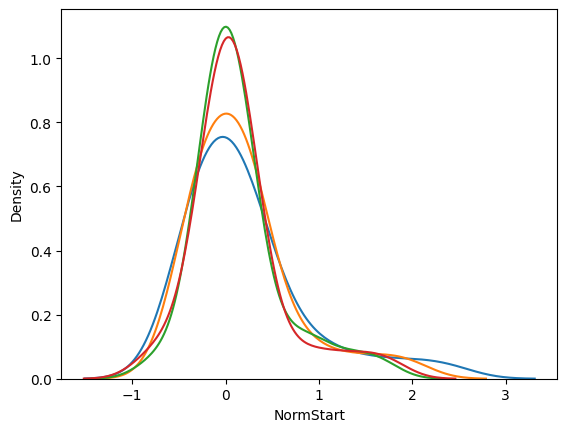

In [310]:
#normalized/fraction of a step rock

sns.kdeplot(data=RelFixTimes, x='NormStart')
sns.kdeplot(data=RelFixTimes, x='NormStop')
sns.kdeplot(data=RelFixTimes, x='RelStart')
sns.kdeplot(data=RelFixTimes, x='RelStop')


<Axes: xlabel='NormStart', ylabel='Density'>

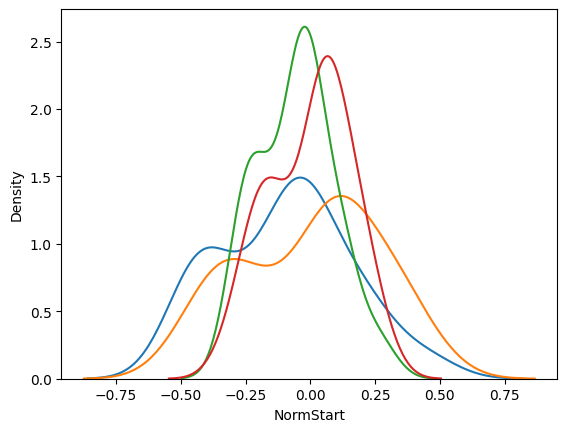

In [320]:
#normalized/fraction of a step medium

sns.kdeplot(data=RelFixTimes_m, x='NormStart')
sns.kdeplot(data=RelFixTimes_m, x='NormStop')
sns.kdeplot(data=RelFixTimes_m, x='RelStart')
sns.kdeplot(data=RelFixTimes_m, x='RelStop')


    

Text(0, 0.5, 'TimeDiff')

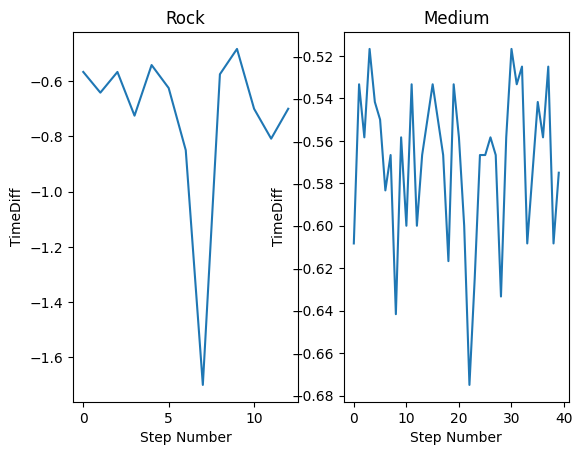

In [316]:
#find step velocity for terrains and compare regressions?
# need distance between steps for vel
#nextdiff here is only for start,left out stop

plt.subplot(1,2,1)
plt.plot(steps_df['nextdiff'])
plt.title('Rock')
plt.xlabel('Step Number')
plt.ylabel('TimeDiff')

plt.subplot(1,2,2)
plt.plot(steps_df_m['nextdiff'])
plt.title('Medium')
plt.xlabel('Step Number')
plt.ylabel('TimeDiff')